# **<span style = 'color:blue'>Part 2: Bi- and Uni-directional LSTM RNNs for Smart Homes Indoor Temperature Forecasting</span>**
Part 1: [Multivariate FBProphet Smart Homes Indoor Temperature Forecasting]( https://www.kaggle.com/rinichristy/multivariate-fbprophet-smart-homes-temperature)

## **<span style='color:green'> Contents:</span>**<a id="Table"></a>

* [1. Import the libraries](#Import)
* [2. Dataset Information](#Dataset)
* [3. Statistical Data Analysis](#Statistical)
* [4. Data Wrangling](#Wrangling)
    - [4.1 Choosing variables correlated with Indoor room temperature](#variables)
    - [4.2 Feature engineering to extract Dateparts](#Dateparts)
    - [4.3 Choosing number of lags](#Lags)
* [5. Build Multivariate Bidirectional & Unidirectional RNN LSTM Time Series Models](#RNN)
    - [5.1 Recurrent neural networks (RNN): Introduction](#Introduction)
    - [5.2 Model: Bidirectional LSTM Architecture](#Bidirectional)
    - [5.3 Model: Unidirectional LSTM Architecture](#Unidirectional)
* [6. Model Train, Evaluation & Final Report](#Report)
    - [6.1 Train & evaluate the model](#Train-Evaluate)
    - [6.2 Model Forecast](#Forecast)
    - [6.3 Kaggle Submission](#Submission)

## **<span style = 'color:green'>1. Import the required libraries</span>**<a id ="Import"></a>

In [1]:
# Import data handling & numerical libraries
import pandas as pd
import numpy as np
from copy import copy
import datetime

# Import Data Visualization libraries
import seaborn as sb
import matplotlib.pyplot as plt

#import libraries for muting unnecessary warnings if needed
import warnings
warnings.filterwarnings('ignore')

## **<span style = 'color:green'>2. Dataset information</span>**<a id ='Dataset'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

The dataset collected from the monitor system mounted in a solar house corresponds to approximately 40 days of monitoring data. The Goal is to predict indoor temperature of a room (the Bedroom), in order to choose whether or not to activate the HVAC (Heating, Ventilation, and Air Conditioning) system. The data was sampled every minute, computing and uploading it smoothed with 15 minute means. The dataset includes dates, other sensor measurements, weather measurements and other information. It is a multivariate time-series dataset.

It has been established that the power consumption attributed to HVAC accounts for 53.9 % of total consumption, and the energy required to maintain the temperature is less than that required to drop or raise it.

As a result, a predictive model capable of predicting a room's indoor temperature (a short-term forecast of indoor temperature) would help in lowering overall energy consumption, by deciding whether or not to activate the HVAC system, at the appropriate time.

Below displayed map provides an idea of locations of solar house sensors and actuators. 

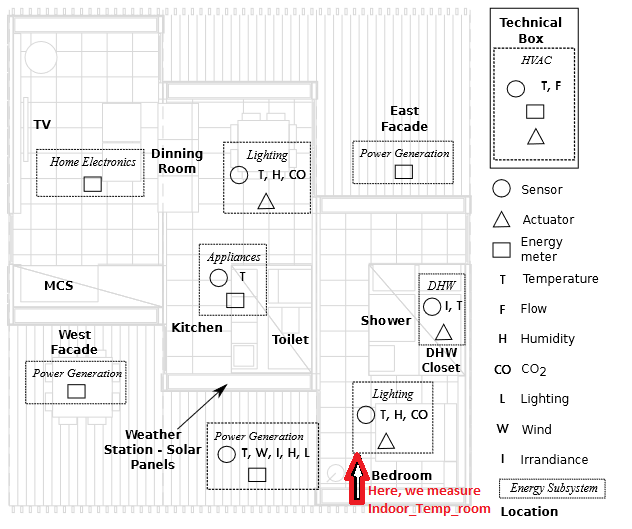

In [2]:
from IPython.display import Image
url = '/content/Solar house sensors and actuators map.png'
Image(url,width=700, height=700)

In [3]:
df = pd.read_csv('/content/train.csv')
df_test1 = pd.read_csv('/content/test.csv')
df.head(2)

,Id,Date,Time,CO2_(dinning-room),CO2_room,Relative_humidity_(dinning-room),Relative_humidity_room,Lighting_(dinning-room),Lighting_room,Meteo_Rain,Meteo_Sun_dusk,Meteo_Wind,Meteo_Sun_light_in_west_facade,Meteo_Sun_light_in_east_facade,Meteo_Sun_light_in_south_facade,Meteo_Sun_irradiance,Outdoor_relative_humidity_Sensor,Day_of_the_week,Indoor_temperature_room
0,0,13/03/2012,11:45,216.560,221.920,39.9125,42.4150,81.6650,113.520,0.0,623.360,1.42625,9690.24,12604.2,95436.8,758.880,48.375,2.0,17.8275
1,1,13/03/2012,12:00,219.947,220.363,39.9267,42.2453,81.7413,113.605,0.0,623.211,1.59200,11022.00,10787.2,95436.8,762.069,47.808,2.0,18.1207


## **<span style='color:green'>3. Statistical Data Analysis</span>**<a id ='Statistical'></a>
See [Part1](https://www.kaggle.com/rinichristy/multivariate-fbprophet-smart-homes-temperature) for this section

## **<span style = 'color:green'>4. Data Wrangling</span>**<a id ='Wrangling'></a>

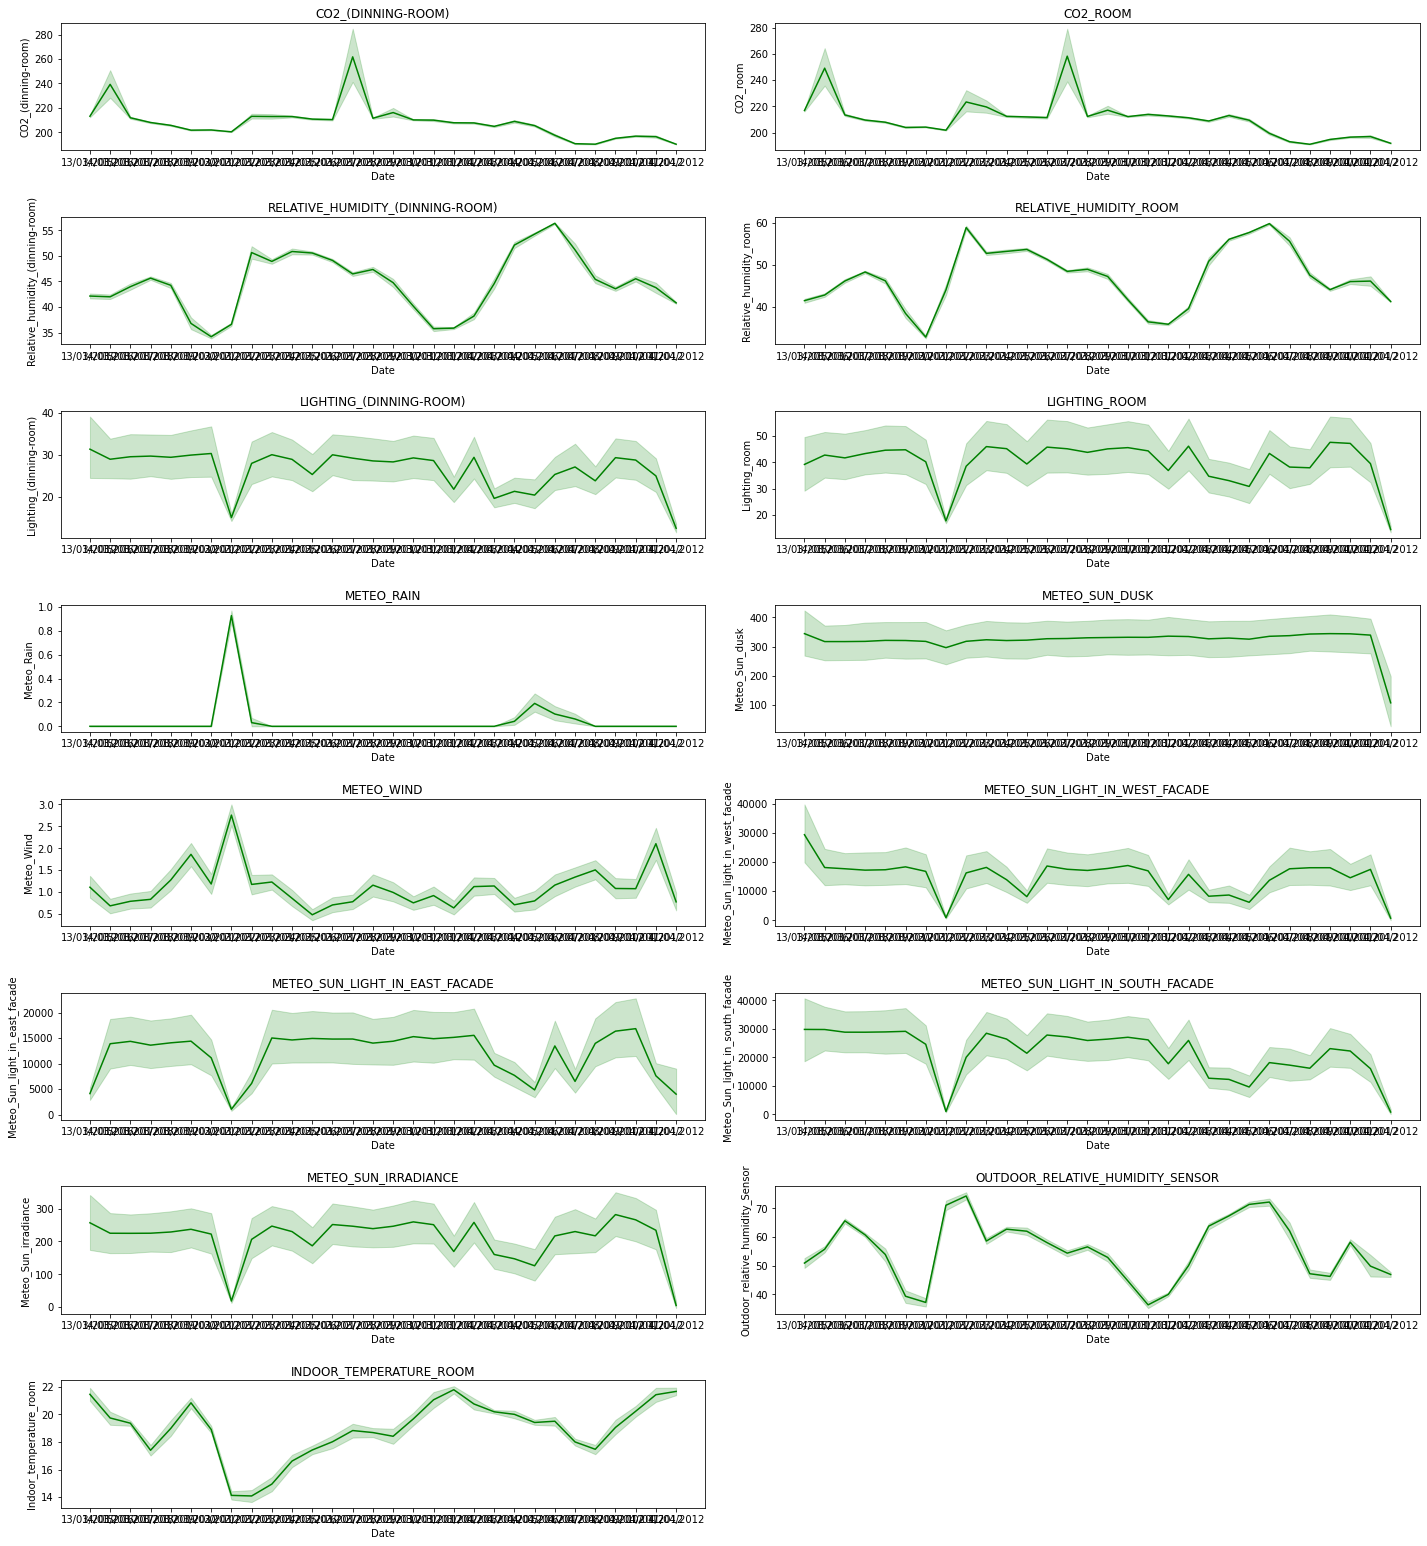

In [4]:
# Numerical features
num_feats=[col for col in df.columns if df[col].dtypes != 'object'  and col !='Day_of_the_week' and col != 'Id']

# Plot distribution of numerical columns
fig=plt.figure(figsize=(20,40))
for i, col in enumerate(num_feats):
    plt.subplot(len(num_feats),2,1*i+1)
    sb.lineplot(df['Date'], df[col], color ='green')
    plt.title(col.upper())  
fig.tight_layout()
plt.show()

### **<span style = 'color:brown'>4.1 Choosing variables correlated with Indoor room temperature</span>**<a id = 'variables'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

**Cross-correlation plot**

To examine the cross-correlation between for example, Sun Irradiance hours and indoor temperature, which is a process subject to seasonal lag - whereby maximum indoor temperature will lag the period of maximum sunlight irradiance.

The matplotlib xcorr() function can be used to plot the cross correlation between Indoor_temperature_room and other variable's time series to determine if a lag is present, and if so by how many time periods. The cross-correlation is plotted for the data as follows:

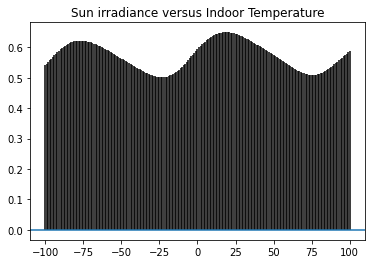

In [5]:
plt.xcorr(df['Indoor_temperature_room'], df['Meteo_Sun_irradiance'], normed=True, usevlines=True, maxlags=100)
plt.title("Sun irradiance versus Indoor Temperature");

In this instance, the strongest correlation between Sun irradiance and Indoor temperature comes lags by approximately 20 days, i.e. this is when the strongest correlation between the two time series is observed. The below xcorrelation plots display the individual influence of parameters such as relative humidity, wind, solar irradiation, lighting etc on indoor temperature. 

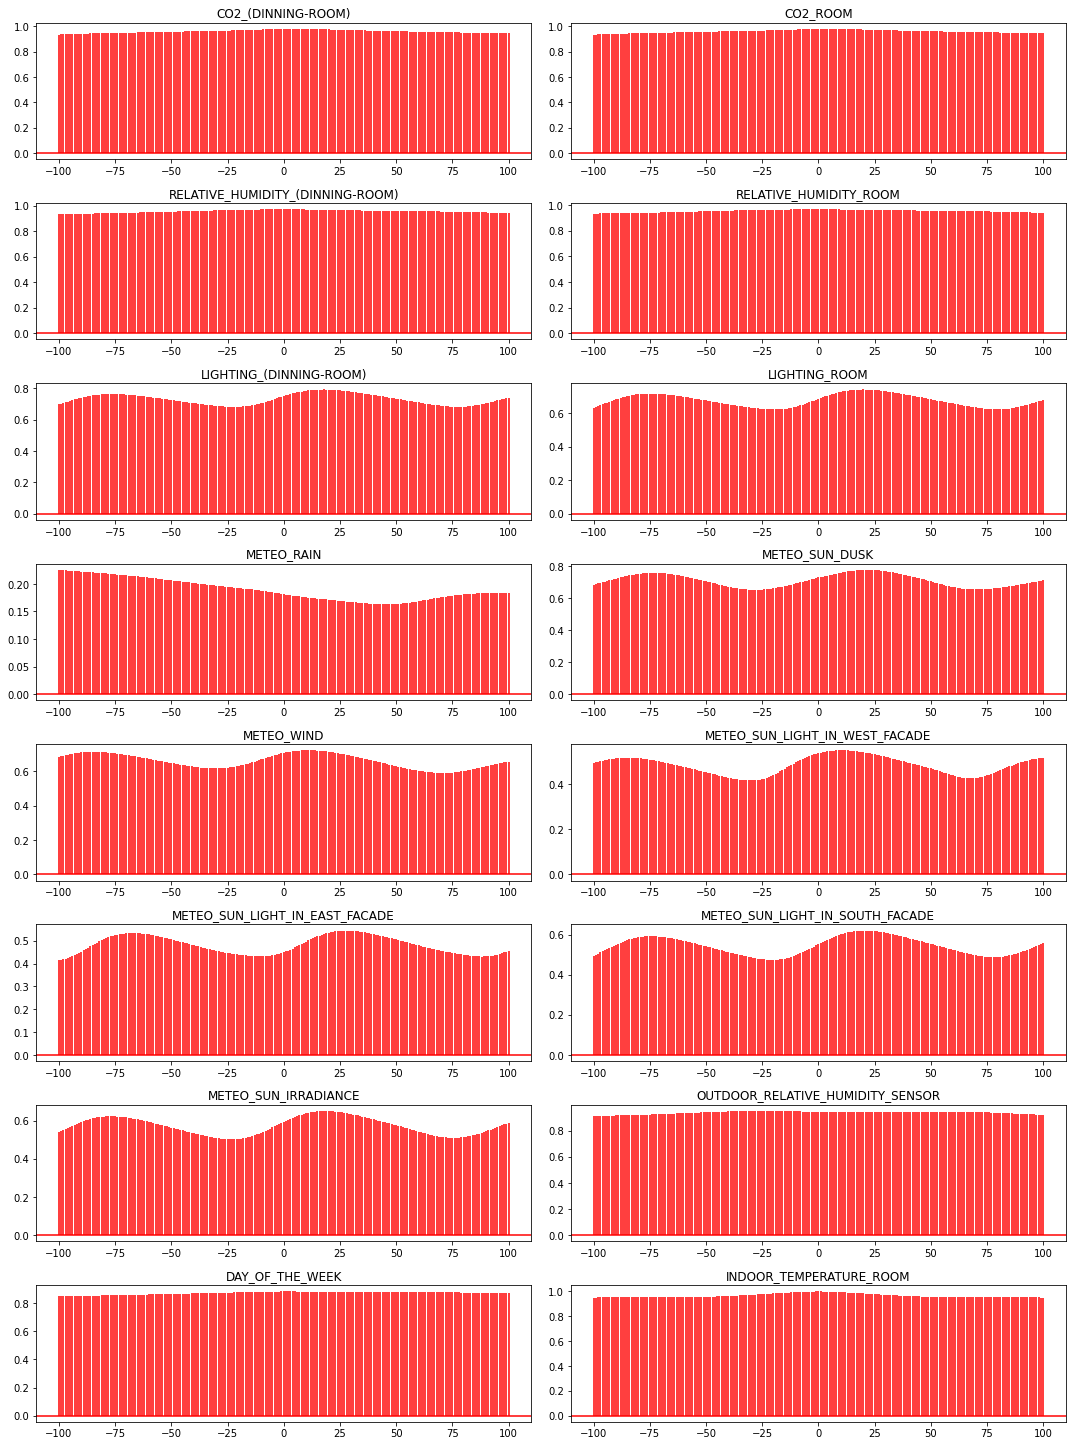

In [6]:
# Numerical features
num_feats=[col for col in df.columns if df[col].dtypes != 'object' and col != 'Id']

# Plot distribution of numerical columns
fig=plt.figure(figsize=(15,40))
for i, col in enumerate(num_feats):
    plt.subplot(len(num_feats),2,1*i+1)
    plt.xcorr(df['Indoor_temperature_room'], df[col], normed=True, usevlines=True, maxlags=100, color = 'red')
    plt.title(col.upper())
    
fig.tight_layout()
plt.show()

Data with a sine or cosine-like wave indicate seasonality, which repeat itself periodically. To know more about this, define a function to make lags using shift method and then call the function on each variable to make any desirable number of lags.

In [7]:
def make_lags(ts, lags, start):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(start, lags + 1)
        },
        axis=1)
X = make_lags(df['Meteo_Sun_irradiance'], lags=25, start = 15)
X

,y_lag_15,y_lag_16,y_lag_17,y_lag_18,y_lag_19,y_lag_20,y_lag_21,y_lag_22,y_lag_23,y_lag_24,y_lag_25
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2759,-3.64267,-3.70800,-3.64267,-3.51200,-3.70800,-3.57733,-3.83867,-3.90400,-3.83867,-3.64267,-3.77333
2760,-3.83867,-3.64267,-3.70800,-3.64267,-3.51200,-3.70800,-3.57733,-3.83867,-3.90400,-3.83867,-3.64267
2761,-3.70800,-3.83867,-3.64267,-3.70800,-3.64267,-3.51200,-3.70800,-3.57733,-3.83867,-3.90400,-3.83867
2762,-3.70800,-3.70800,-3.83867,-3.64267,-3.70800,-3.64267,-3.51200,-3.70800,-3.57733,-3.83867,-3.90400


In [8]:
X['Indoor_temperature_room'] = df['Indoor_temperature_room']
X.loc[25:, :].corr()['Indoor_temperature_room'].sort_values(ascending = False)[0:5]

Indoor_temperature_room    1.000000
y_lag_19                   0.586102
y_lag_18                   0.585009
y_lag_20                   0.584844
y_lag_17                   0.581405
Name: Indoor_temperature_room, dtype: float64

In [9]:
z = make_lags(df['Lighting_room'], lags=25, start = 15)
z = z.fillna(0)
z['Indoor_temperature_room'] = df['Indoor_temperature_room']
z.loc[25:, :].corr()['Indoor_temperature_room'].sort_values(ascending = False)[0:5]

Indoor_temperature_room    1.000000
y_lag_21                   0.536779
y_lag_20                   0.536029
y_lag_22                   0.535330
y_lag_19                   0.532963
Name: Indoor_temperature_room, dtype: float64

In [10]:
z = make_lags(df['Meteo_Wind'], lags=50, start = 1)
z = z.fillna(0)
z['Indoor_temperature_room'] = df['Indoor_temperature_room']
abs(z.loc[25:, :].corr()['Indoor_temperature_room']).sort_values(ascending = False)[0:5]

Indoor_temperature_room    1.000000
y_lag_12                   0.365277
y_lag_11                   0.364461
y_lag_13                   0.364135
y_lag_10                   0.361828
Name: Indoor_temperature_room, dtype: float64

In [11]:
df_train1 = df.copy()
df_test = df_test1.copy()
df_train_test=pd.concat([df.drop(['Indoor_temperature_room'],axis=1),df_test1],ignore_index=True)
df_train_test

,Id,Date,Time,CO2_(dinning-room),CO2_room,Relative_humidity_(dinning-room),Relative_humidity_room,Lighting_(dinning-room),Lighting_room,Meteo_Rain,Meteo_Sun_dusk,Meteo_Wind,Meteo_Sun_light_in_west_facade,Meteo_Sun_light_in_east_facade,Meteo_Sun_light_in_south_facade,Meteo_Sun_irradiance,Outdoor_relative_humidity_Sensor,Day_of_the_week
0,0,13/03/2012,11:45,216.560,221.920,39.9125,42.4150,81.6650,113.5200,0.0,623.360,1.426250,9690.24,12604.20,95436.80,758.880,48.3750,2.0
1,1,13/03/2012,12:00,219.947,220.363,39.9267,42.2453,81.7413,113.6050,0.0,623.211,1.592000,11022.00,10787.20,95436.80,762.069,47.8080,2.0
2,2,13/03/2012,12:15,219.403,218.933,39.7720,42.2267,81.4240,113.6000,0.0,622.656,1.891330,13960.50,9669.63,95398.60,766.251,47.4320,2.0
3,3,13/03/2012,12:30,218.613,217.045,39.7760,42.0987,81.5013,113.3440,0.0,622.571,1.828000,18511.20,9648.13,95360.30,766.037,47.0240,2.0
4,4,13/03/2012,12:45,217.714,216.080,39.7757,42.0686,81.4657,113.0340,0.0,622.400,2.360710,26349.00,9208.32,95354.90,762.743,45.4743,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4132,4132,02/05/2012,06:30,199.424,201.963,43.0160,44.9813,21.8500,24.3493,0.0,617.067,0.295333,6636.54,35671.40,7454.38,124.496,58.9920,3.0
4133,4133,02/05/2012,06:45,199.200,202.091,43.1920,44.9413,21.1653,30.9693,0.0,618.133,0.174000,11818.30,71188.50,12526.90,256.597,58.6213,3.0
4134,4134,02/05/2012,07:00,199.435,201.739,43.3947,44.9333,21.2640,32.1933,0.0,619.285,0.246000,10836.30,69498.20,12597.90,281.568,57.6960,3.0
4135,4135,02/05/2012,07:15,200.107,200.597,43.3440,44.7013,28.1647,38.3507,0.0,620.139,0.181333,11722.10,79102.00,15796.90,354.645,56.8613,3.0


### **<span style = 'color:brown'>4.2 Feature engineering to extract Dateparts</span>**<a id = 'Dateparts'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

In [12]:
def preprocss_data(df):
    df1 = df.copy()
    df1['Date'] = pd.to_datetime(df1['Date'], dayfirst=True)
    df1['Date'] = df1['Date'].dt.strftime('%Y-%m-%d')

    df1['DateTime'] = df1['Date'] + ' ' + df1['Time']
    df1['DateTime'] = pd.to_datetime(df1['DateTime'])
    df1.drop(['Date','Time'], axis = 1, inplace = True)
    
    from fastai.tabular.core import add_datepart
    # make a Date copy because "add_datepart" do delete the orginal formatted Date.
    #In other words, the function transfer the column to Date Parts
    df_formatted = df1.copy()
    df_formatted['Formatted Date'] = df_formatted["DateTime"]
    df_formatted = add_datepart(df_formatted, 'Formatted Date')
    df_formatted.head()
    
    def hours2timing(x):
        if x in [22,23,0,1,2,3]:
            timing = 'Night'
        elif x in range(4, 12):
            timing = 'Morning'
        elif x in range(12, 17):
            timing = 'Afternoon'
        elif x in range(17, 22):
            timing = 'Evening'
        else:
            timing = 'X'
        return timing

    df_formatted['hour'] = df_formatted['DateTime'].apply(lambda x : x.hour)
    df_formatted['timing'] = df_formatted['hour'].apply(hours2timing)
    timing = df_formatted[['timing']]
    
    
    #OrdinalEncoder from scikit learn, which allows multi-column encoding 
    # It can be used to convert categorical features in numerical data type.
    from sklearn.preprocessing import OrdinalEncoder
    for i in df_formatted.select_dtypes(['object', 'bool']).columns:
        Oe = OrdinalEncoder().fit(df_formatted[[i]])
        df_formatted[i] = Oe.transform(df_formatted[[i]]).astype(int)
    return  df_formatted

df_formatted_train_test = preprocss_data(df_train_test)
df_formatted_train = preprocss_data(df)
df_formatted_train

,Id,CO2_(dinning-room),CO2_room,Relative_humidity_(dinning-room),Relative_humidity_room,Lighting_(dinning-room),Lighting_room,Meteo_Rain,Meteo_Sun_dusk,Meteo_Wind,...,Formatted Dayofyear,Formatted Is_month_end,Formatted Is_month_start,Formatted Is_quarter_end,Formatted Is_quarter_start,Formatted Is_year_end,Formatted Is_year_start,Formatted Elapsed,hour,timing
0,0,216.560,221.920,39.9125,42.4150,81.6650,113.5200,0.0,623.360,1.426250,...,73,0,0,0,0,0,0,1.331639e+09,11,2
1,1,219.947,220.363,39.9267,42.2453,81.7413,113.6050,0.0,623.211,1.592000,...,73,0,0,0,0,0,0,1.331640e+09,12,0
2,2,219.403,218.933,39.7720,42.2267,81.4240,113.6000,0.0,622.656,1.891330,...,73,0,0,0,0,0,0,1.331641e+09,12,0
3,3,218.613,217.045,39.7760,42.0987,81.5013,113.3440,0.0,622.571,1.828000,...,73,0,0,0,0,0,0,1.331642e+09,12,0
4,4,217.714,216.080,39.7757,42.0686,81.4657,113.0340,0.0,622.400,2.360710,...,73,0,0,0,0,0,0,1.331643e+09,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,2759,190.539,192.181,41.3120,41.6880,11.4427,12.9400,0.0,392.603,0.074667,...,102,0,0,0,0,0,0,1.334122e+09,5,2
2760,2760,190.421,193.067,41.3173,41.7200,11.6867,19.3200,0.0,613.120,0.000000,...,102,0,0,0,0,0,0,1.334123e+09,5,2
2761,2761,190.432,193.653,41.3333,41.7573,19.5387,23.2427,0.0,613.803,0.310667,...,102,0,0,0,0,0,0,1.334124e+09,6,2
2762,2762,191.531,193.387,41.3093,41.8107,20.9853,23.4400,0.0,615.403,0.299333,...,102,0,0,0,0,0,0,1.334125e+09,6,2


Plot the xcorr plot of the entire formatted dataset once again to hunt for new added features, if any. 

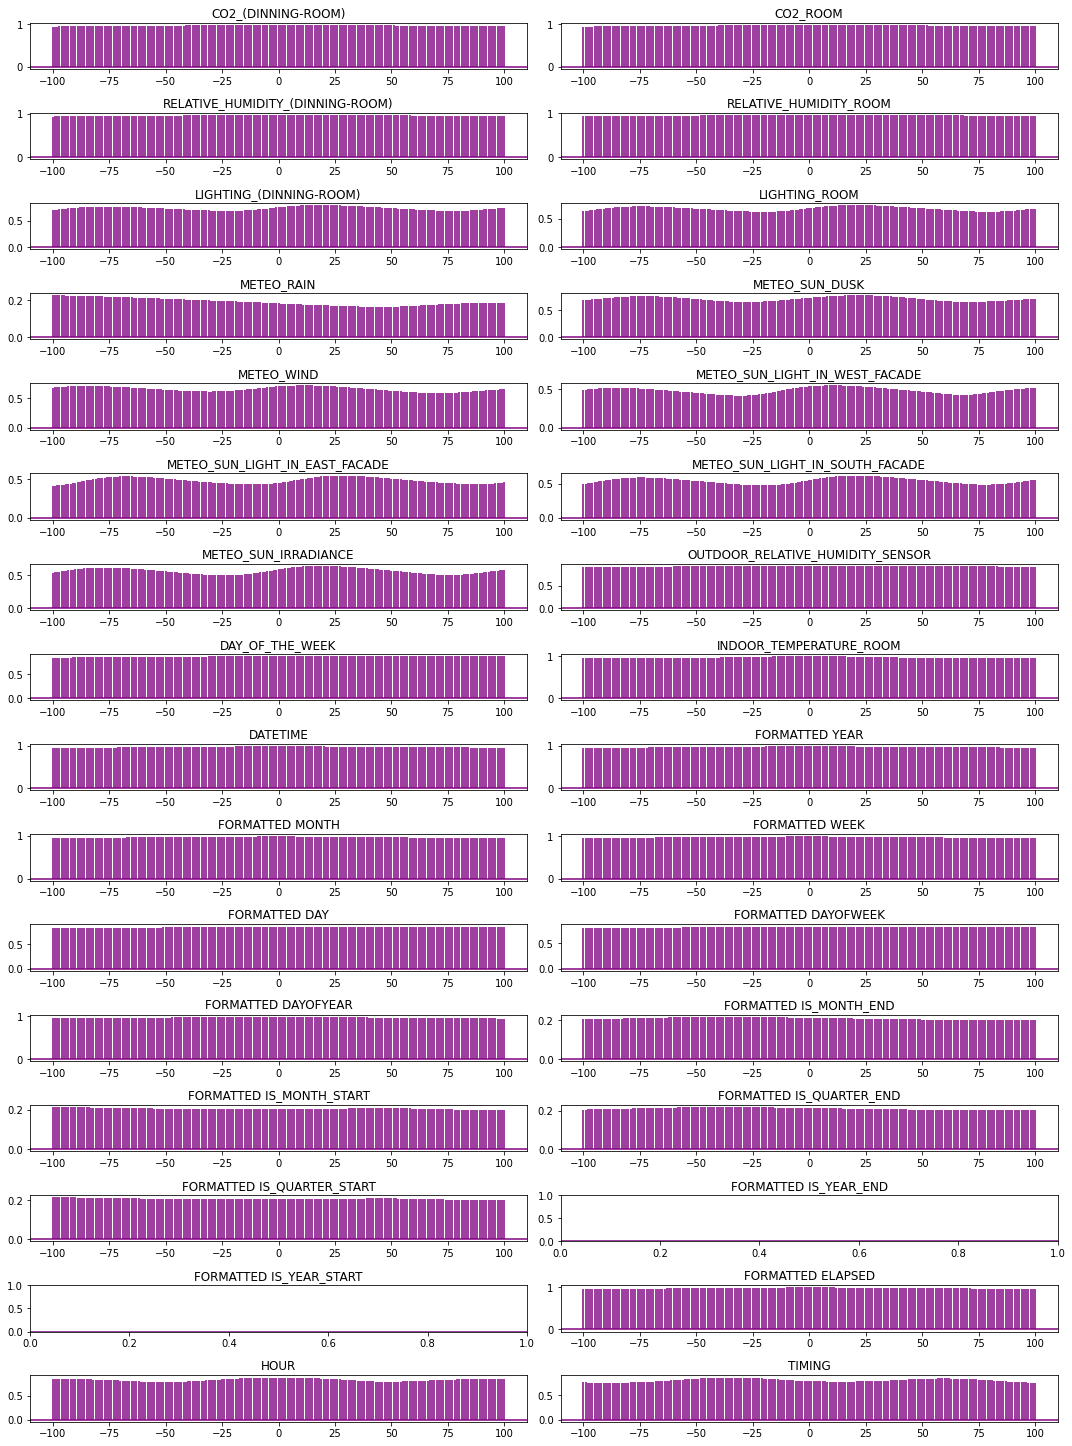

In [13]:
# Numerical features
num_feats=[col for col in df_formatted_train.columns if df_formatted_train[col].dtypes != 'object' and col != 'Id']

# Plot distribution of numerical columns
fig=plt.figure(figsize=(15,40))
for i, col in enumerate(num_feats):
    plt.subplot(len(num_feats),2,1*i+1)
    plt.xcorr(df_formatted_train['Indoor_temperature_room'], df_formatted_train[col], normed=True, usevlines=True, maxlags=100, color = 'purple')
    plt.title(col.upper())
    
fig.tight_layout()
plt.show()

Make lags of some of the numerical columns and check their corresponding correlation with 'Indoor_temperature_room' to find the lag that has the most impact on temperature.

In [14]:
hr = make_lags(df_formatted_train['hour'], lags=25, start=1)
hr = hr.fillna(0)
hr['Indoor_temperature_room'] = df['Indoor_temperature_room']
hr.corr()['Indoor_temperature_room'].sort_values(ascending = False)[0:5]

Indoor_temperature_room    1.000000
y_lag_1                    0.416555
y_lag_2                    0.413920
y_lag_3                    0.409978
y_lag_4                    0.404769
Name: Indoor_temperature_room, dtype: float64

In [15]:
timing = make_lags(df_formatted_train['timing'], lags=10, start = 1)
timing = timing.fillna(0)
timing['Indoor_temperature_room'] = df['Indoor_temperature_room']
abs(timing.corr()['Indoor_temperature_room']).sort_values(ascending = False)[0:5]

Indoor_temperature_room    1.000000
y_lag_9                    0.477644
y_lag_8                    0.476908
y_lag_10                   0.476896
y_lag_7                    0.474767
Name: Indoor_temperature_room, dtype: float64

In [16]:
humidity = make_lags(df_formatted_train['Outdoor_relative_humidity_Sensor'], lags=25, start = 1)
humidity = humidity.fillna(0)
humidity['Indoor_temperature_room'] = df['Indoor_temperature_room']
abs(humidity.corr()['Indoor_temperature_room']).sort_values(ascending = False)[0:5]

Indoor_temperature_room    1.000000
y_lag_6                    0.568856
y_lag_7                    0.568532
y_lag_5                    0.568204
y_lag_8                    0.567245
Name: Indoor_temperature_room, dtype: float64

Now, start building the training dataset to fit the model. 

In [17]:
df_formatted_train_test1 = df_formatted_train_test.copy()
df_train=pd.merge(df_formatted_train_test1,df[['Id','Indoor_temperature_room']],on='Id')
df_train = df_train.fillna(method = 'bfill')
df_train

,Id,CO2_(dinning-room),CO2_room,Relative_humidity_(dinning-room),Relative_humidity_room,Lighting_(dinning-room),Lighting_room,Meteo_Rain,Meteo_Sun_dusk,Meteo_Wind,...,Formatted Is_month_end,Formatted Is_month_start,Formatted Is_quarter_end,Formatted Is_quarter_start,Formatted Is_year_end,Formatted Is_year_start,Formatted Elapsed,hour,timing,Indoor_temperature_room
0,0,216.560,221.920,39.9125,42.4150,81.6650,113.5200,0.0,623.360,1.426250,...,0,0,0,0,0,0,1.331639e+09,11,2,17.8275
1,1,219.947,220.363,39.9267,42.2453,81.7413,113.6050,0.0,623.211,1.592000,...,0,0,0,0,0,0,1.331640e+09,12,0,18.1207
2,2,219.403,218.933,39.7720,42.2267,81.4240,113.6000,0.0,622.656,1.891330,...,0,0,0,0,0,0,1.331641e+09,12,0,18.4367
3,3,218.613,217.045,39.7760,42.0987,81.5013,113.3440,0.0,622.571,1.828000,...,0,0,0,0,0,0,1.331642e+09,12,0,18.7513
4,4,217.714,216.080,39.7757,42.0686,81.4657,113.0340,0.0,622.400,2.360710,...,0,0,0,0,0,0,1.331643e+09,12,0,19.0414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,2759,190.539,192.181,41.3120,41.6880,11.4427,12.9400,0.0,392.603,0.074667,...,0,0,0,0,0,0,1.334122e+09,5,2,20.8187
2760,2760,190.421,193.067,41.3173,41.7200,11.6867,19.3200,0.0,613.120,0.000000,...,0,0,0,0,0,0,1.334123e+09,5,2,20.7053
2761,2761,190.432,193.653,41.3333,41.7573,19.5387,23.2427,0.0,613.803,0.310667,...,0,0,0,0,0,0,1.334124e+09,6,2,20.5827
2762,2762,191.531,193.387,41.3093,41.8107,20.9853,23.4400,0.0,615.403,0.299333,...,0,0,0,0,0,0,1.334125e+09,6,2,20.5200


In [18]:
df_train_lag = df_train.copy()
df_train_lag['Meteo_Sun_irradiance'] = df_train_lag['Meteo_Sun_irradiance'].shift(19)
df_train_lag['Lighting_room'] = df_train_lag['Lighting_room'].shift(21)
df_train_lag['Outdoor_relative_humidity_Sensor'] = df_train_lag['Outdoor_relative_humidity_Sensor'].shift(6)
df_train_lag['Meteo_Wind'] = df_train_lag['Meteo_Wind'].shift(12)

In [19]:
corr = df_train_lag.drop(['Id', 'DateTime'], axis = 1).corr()
abs(corr['Indoor_temperature_room']).sort_values(ascending = False)[0:10]

Indoor_temperature_room             1.000000
Meteo_Sun_irradiance                0.588970
Outdoor_relative_humidity_Sensor    0.581000
Lighting_room                       0.538869
Relative_humidity_room              0.417901
hour                                0.417876
timing                              0.410144
Meteo_Wind                          0.369261
Meteo_Sun_light_in_west_facade      0.335288
Relative_humidity_(dinning-room)    0.275193
Name: Indoor_temperature_room, dtype: float64

In [20]:
print(df_formatted_train_test[['Lighting_room', 'Meteo_Sun_irradiance']].corr())

                      Lighting_room  Meteo_Sun_irradiance
Lighting_room              1.000000              0.922889
Meteo_Sun_irradiance       0.922889              1.000000


* After applying lag, it is clearly visible that Meteo_Sun_irradiance is the most correlated with Indoor temperature. 
* This is then followed by Outdoor_relative_humidity_Sensor, 
* and thenby 'Lighting_room', which is almost perfectly collinear to sun irradiance (0.92). So either one should be selected and it is better to drop Lighting from the list because it is the direct effect of the irradiance. 
* Next in the list is  'Relative_humidity_room' 
* and 'hour' also have moderate correlation with Indoor temperature.  

### **<span style = 'color:brown'>4.3 Choosing number of lags</span>**<a id ="Lags"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

#### **Lag plot**

A lag plot to compare indoor room temperature autocorrelationfrom each observation in the dataset against the one from a previous observation. 

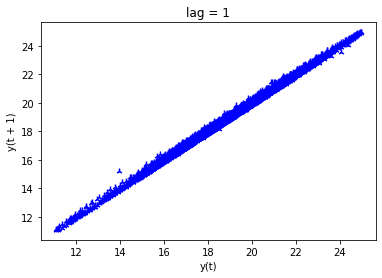

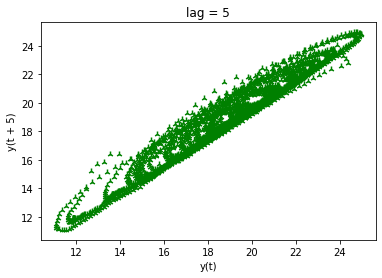

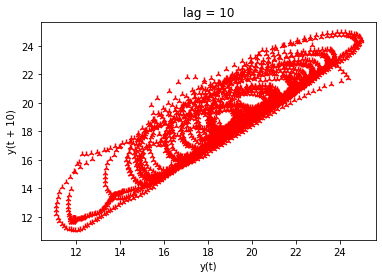

In [21]:
#from pandas import plotting
#plotting.lag_plot(df['Indoor_temperature_room'], lag=1, marker='2', c='blue')

from pandas.plotting import lag_plot
plt.figure()
lag_plot(df['Indoor_temperature_room'], lag=1, marker='2', c='blue')
plt.title('lag = 1')
plt.figure()
lag_plot(df['Indoor_temperature_room'], lag=5, marker='2', c='green')
plt.title('lag = 5');
plt.figure()
lag_plot(df['Indoor_temperature_room'], lag=10, marker='2', c='red')
plt.title('lag = 10');


If the plot shows a linear pattern, it suggests autocorrelation is present. A positive linear trend (i.e. going upwards from left to right) is suggestive of positive autocorrelation and the tighter the data is clustered around the diagonal, the more autocorrelation is present; perfectly autocorrelated data will cluster in a single diagonal line.
Since the lag plot is linear, the underlying structure is of the autoregressive in nature. The linear shape to the plot suggests that an autoregressive model with 1 lag is probably the best choice for this data. Almost the entire values are concentrated on the diagonal in lag plot, it suggests a strong autocorrelation.

The plots overlapped on top of each other shows the difference in dispersion of points on increasing the lags. 

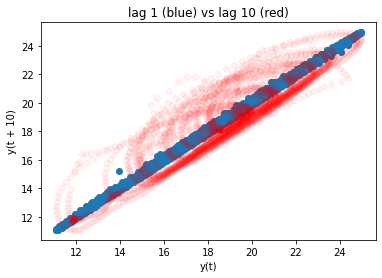

In [22]:
from pandas import plotting
plt.figure()
plotting.lag_plot(df['Indoor_temperature_room'], lag=1)
plotting.lag_plot(df['Indoor_temperature_room'], lag=10, c= 'red', alpha =0.05)
plt.title('lag 1 (blue) vs lag 10 (red)');

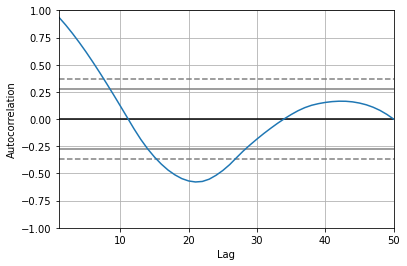

In [23]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['Indoor_temperature_room'].head(50));

#### **Partial Autocorrelation Plot of the Indoor Temperatures**

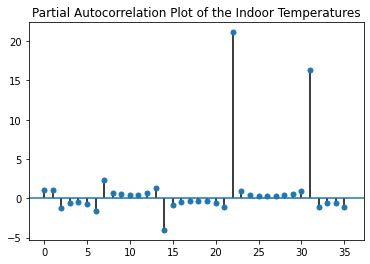

In [24]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['Indoor_temperature_room'], title = "Partial Autocorrelation Plot of the Indoor Temperatures");

The lag plots indicate that the relationship of Indoor temperature to its lags is mostly linear, while the partial autocorrelation suggests the dependence can be captured efficiently using lags 1, 2, 3, 7, 8 etc. Since xcorr plot shows a correlation at 4 lags for 'Outdoor_relative_humidity_Sensor', 1 for 'hour' and 19 for 'Meteo_Sun_irradiance', it is better to settle with a lag of 8 for building the memory of the model. So this is going to be a multivariate time series with Meteo_Sun_irradiance','hour','Outdoor_relative_humidity_Sensor', and 'Indoor_temperature_room' and their lag of 8 to be the independent variables for predicting the dependent variable 'Indoor_temperature_room'.

A sample test with Linear regression is run as follows:

First, a univariate autocorrelation run.

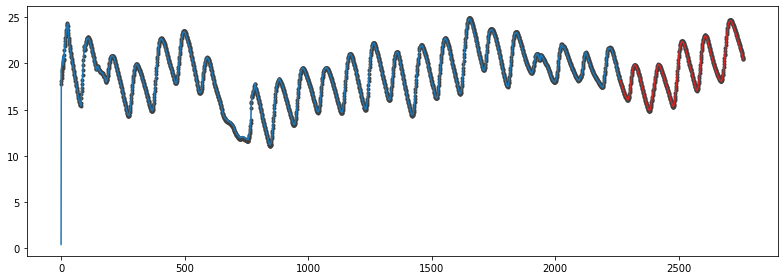

In [25]:
# Create target series and data splits
X = make_lags(df.Indoor_temperature_room, lags=8, start = 1)
X = X.fillna(0.0)

y = df.Indoor_temperature_room.copy()
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=500, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

plt.rc("figure", autolayout=True, figsize=(11, 4))

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')


To improve the forecast add some leading indicators, time series that could provide an "early warning" for changes in temperature changes. For this approach add those above mentioned variables to the training data. 

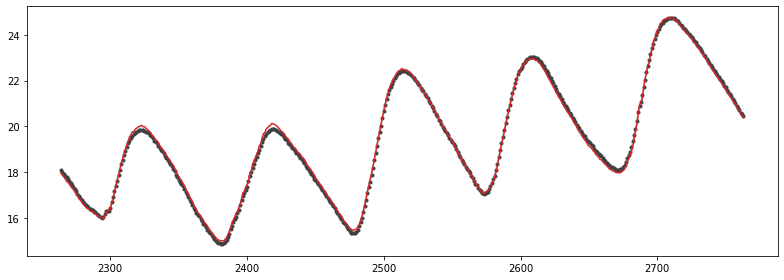

In [26]:
ts = df_train[['Meteo_Sun_irradiance', 'hour', 'Outdoor_relative_humidity_Sensor']]
# Create three lags for each search term
X0 = make_lags(ts, lags=8, start=1)

# Create four lags for the target, as before
X1 = make_lags(df_train['Indoor_temperature_room'], lags=8, start=1)

# Combine to create the training data
X = pd.concat([X0, X1], axis=1).fillna(0.0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=500, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')


Even though it looks simple yet promising, with this approach past known values required to be used to predict the unknown values get exhausted at the end of the series. Only the very next value can be predicted. The forecast comes to a halt beyond the first value of the test set where the dependent variable is unknown to the model. To predict a very long series  another model is required which can retain the memory and carry it forward to next in line till the end.  Here comes the advantage of RNN over these models. 

## **<span style = 'color:green'>5. Build Multivariate Bidirectional & Unidirectional RNN LSTM Time Series Models**<a id ='RNN'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)
### **<span style = 'color:brown'>5.1 Recurrent neural networks (RNN): Introduction</span>**<a id = 'Introduction'></a>
The main advantage of using Recurrent neural networks (RNN) is its ability to learn from the immediately preceding data in a sequence like Time series.  It remembers the sequence of the data and uses any patterns involved to make the prediction with the help of feedback loops. By gathering information from the previous loop, it converts both dependent and independent variable to its memory for its prediction of next future dependent value. However it suffers from vanishing or exploding gradient issues, because of which the network doesn’t learn much from the data which is far away from the current position. To overcome this problem Long Short Term Memory Networks, (LSTM) can be used. An LSTM is capable of learning long-term dependencies using short term memory by means of input, output, and forget gates. These gates help to remember the crucial information and forgets the unnecessary information that it learns throughout the network.
    
The chosen variables are: 'Meteo_Sun_irradiance','hour','Outdoor_relative_humidity_Sensor', 'Indoor_temperature_room'

In [27]:
df_train=df_train[['Meteo_Sun_irradiance','hour','Outdoor_relative_humidity_Sensor', 'Indoor_temperature_room']]

#### **<span style = 'color:purple'>Scaling the data</span>**
This is required for faster processing of data and also to remove any bias that may arise due to difference in range of variables, if any.

In [28]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
scaler.fit(df_train)
df_train_scaled =scaler.transform(df_train)
print(df_train_scaled[0:3], '\n, \n')
df_train_scaled.shape

[[ 1.83010123 -0.07489094 -0.58437731 -0.35358727]
 [ 1.84083209  0.06915816 -0.62793488 -0.24964025]
 [ 1.85490436  0.06915816 -0.65681962 -0.13761003]] 
, 



(2764, 4)

#### **<span style = 'color:purple'>Create a new multivariate timeseies dataset with lag features suitable for forecast</span>**
Loop through the data to create multivariate, multistep predictors (X) and target (y) arrays that will allow the model to see past 8 instances of data (lags) and forecast the next 3 instances (forecasts). 

In [29]:
lags=8
forecasts=3
X, y = [], []
for i in range(len(df_train_scaled) - forecasts-lags):
  X.append(df_train_scaled[i:(i + lags)])
  y.append(df_train_scaled[:,-1][i+lags: i+lags+ forecasts])
X,y =  np.array(X), np.array(y)
df_train_scaled.shape, X.shape, y.shape,

((2764, 4), (2753, 8, 4), (2753, 3))

#### **<span style = 'color:purple'>Train- Validation Split</span>**
The training will occur on 8/10th of the data, reserving the last 2/10th for validation.

In [30]:
size = int(len(X) * 0.80)
X_train = X[0:size]
y_train = y[0:size]
X_val = X[size:len(X)]
y_val = y[size:len(X)]
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2202, 8, 4), (2202, 3), (551, 8, 4), (551, 3))

In [31]:
X_train, y_train, X_val, y_val[0:5]

(array([[[ 1.83010123, -0.07489094, -0.58437731, -0.35358727],
         [ 1.84083209,  0.06915816, -0.62793488, -0.24964025],
         [ 1.85490436,  0.06915816, -0.65681962, -0.13761003],
         ...,
         [ 1.80924857,  0.21320726, -0.80165046,  0.16040454],
         [ 1.76976412,  0.21320726, -0.84610684,  0.25236858],
         [ 1.70300329,  0.21320726, -0.8297209 ,  0.32114663]],
 
        [[ 1.84083209,  0.06915816, -0.62793488, -0.24964025],
         [ 1.85490436,  0.06915816, -0.65681962, -0.13761003],
         [ 1.85418426,  0.06915816, -0.68816263, -0.02607614],
         ...,
         [ 1.76976412,  0.21320726, -0.84610684,  0.25236858],
         [ 1.70300329,  0.21320726, -0.8297209 ,  0.32114663],
         [ 1.62992644,  0.21320726, -0.81169098,  0.40573654]],
 
        [[ 1.85490436,  0.06915816, -0.65681962, -0.13761003],
         [ 1.85418426,  0.06915816, -0.68816263, -0.02607614],
         [ 1.84310008,  0.06915816, -0.80721231,  0.07677185],
         ...,
       


### **<span style = 'color:brown'>5.2 Model: Bidirectional LSTM Architecture</span>**<a id ='Bidirectional'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)
While Uni directional LSTM RNN calculates the results of forwarding LSTM, Bi-Directional LSTM RNN deals with both forward and backward LSTM. A Bidirectional RNN is a combination of two RNNs training the network in opposite directions, one from the beginning to the end of a sequence, and the other, from the end to the beginning of a sequence, ie., past to future and future to past. This is achieved by adding one more LSTM layer, which reverses the direction of information flow by which the input sequence flows backward in the additional LSTM layer. Here in the below codes a bi-LSTM layer using keras is added in to a regular neural network. This is done by the following way: 

1. import the Bidirectional class and LSTM class provided by keras to implement Bi-LSTM in keras.
2. Next step is to wrap the LSTM layer inside the Bidirectional class.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 8, 512)           534528    
 l)                                                              
                                                                 
 dense (Dense)               (None, 8, 20)             10260     
                                                                 
 bidirectional_1 (Bidirectio  (None, 8, 256)           152576    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 8, 20)             5140      
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              152576    
 nal)                                                            
                                                        

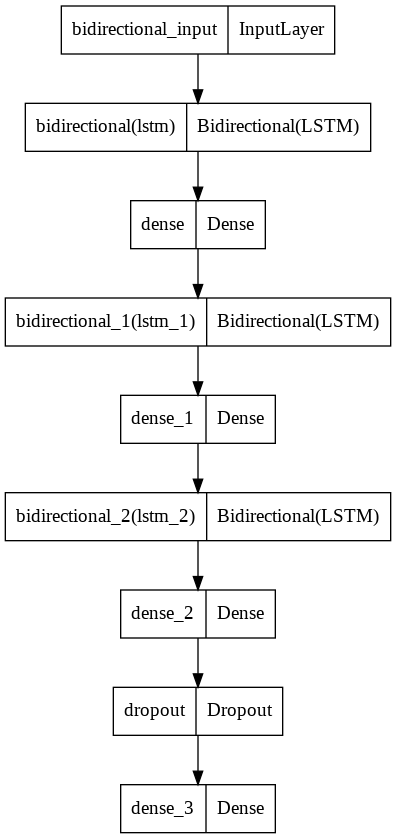

In [32]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
#from keras.layers import GRU
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional

n_steps = X_train.shape[-2]
n_features =X_train.shape[-1]
input_shape=(n_steps, n_features)
model_bi = Sequential([Bidirectional(LSTM(256, return_sequences=True), input_shape= input_shape),
    Dense(20, activation='tanh'),
    Bidirectional(LSTM(128,return_sequences=True, activation = 'tanh')),
    Dense(20, activation='tanh'),
    Bidirectional(LSTM(128,return_sequences=False, activation = 'tanh')),
    Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.20),
    Dense(units=3, activation = 'linear'),
])
model_bi.compile(optimizer='adam', loss='mse')
model_bi.summary()
tf.keras.utils.plot_model(model_bi)

### **<span style = 'color:brown'>5.2 Model: Unidirectional LSTM Architecture</span>**<a id ='Unidirectional'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)
The model consists of input, 2 hidden layers and 1 output layer with 3 dense units corresponding to 3 forecasts. The input to the hidden layer with 64 units comes from the input layer with defined shape and 128 units. All the nodes are fully connected. The output of the hidden layer will go to the second hidden layer with 64 units layer in the network, which is then going to the final and output layer with 3 nodes. All layers except the final one will have the same tanh activation. The activation function for the final dense output layer will be linear. The code for adding this layer is as follows:

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 8, 128)            68096     
                                                                 
 dropout_1 (Dropout)         (None, 8, 128)            0         
                                                                 
 lstm_4 (LSTM)               (None, 8, 64)             49408     
                                                                 
 dropout_2 (Dropout)         (None, 8, 64)             0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 3)                 195       
                                                                 
Total params: 150,723
Trainable params: 150,723
Non-tr

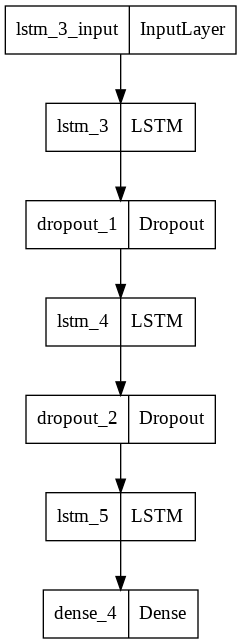

In [33]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import GRU
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

n_steps = X_train.shape[-2]
n_features =X_train.shape[-1]
#input_shape=(n_steps, n_features)
model=Sequential()
model.add(LSTM(128,activation='tanh',return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(64,activation='tanh',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64,activation='tanh'))
model.add(Dense(3, activation='linear'))
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
model.summary()
tf.keras.utils.plot_model(model)

## **<span style = 'color:green'>6. Model Train, Evaluation & Final Report</span>**<a id ='Report'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table) 

### **<span style = 'color:brown'>6.1 Train & evaluate the model</span>**<a id = 'Train-Evaluate'></a>
Define a function to train & evaluate the model.

Epoch 1/6
69/69 [==============================] - 22s 140ms/step - loss: 0.1623 - val_loss: 0.0047
Epoch 2/6
69/69 [==============================] - 6s 92ms/step - loss: 0.0472 - val_loss: 0.0154
Epoch 3/6
69/69 [==============================] - 6s 92ms/step - loss: 0.0411 - val_loss: 0.0079
Epoch 4/6
69/69 [==============================] - 6s 94ms/step - loss: 0.0424 - val_loss: 0.0043
Epoch 5/6
69/69 [==============================] - 7s 95ms/step - loss: 0.0383 - val_loss: 0.0203
Epoch 6/6
69/69 [==============================] - 6s 93ms/step - loss: 0.0353 - val_loss: 0.0049


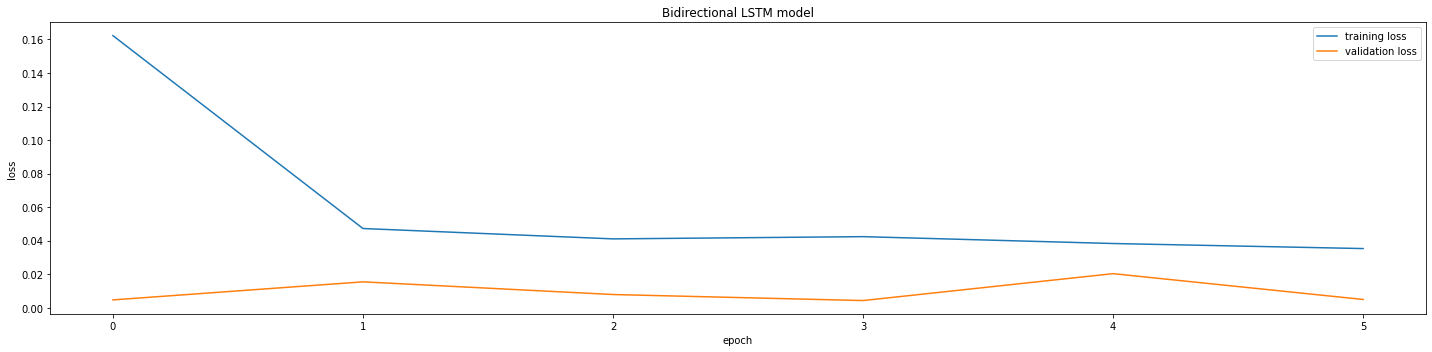


 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Bidirectional LSTM model : 0.0713085010224339
Mean Squared Error(MSE) of Bidirectional LSTM model : 0.008811358001229569
Root Mean Squared Error (RMSE) of Bidirectional LSTM model : 0.09369683265172962
Mean absolute percentage error (MAPE) of Bidirectional LSTM model : 0.7336693155331018
Explained Variance Score (EVS) of Bidirectional LSTM model : 0.9893627191219109
R2 of Bidirectional LSTM model : 0.99

 



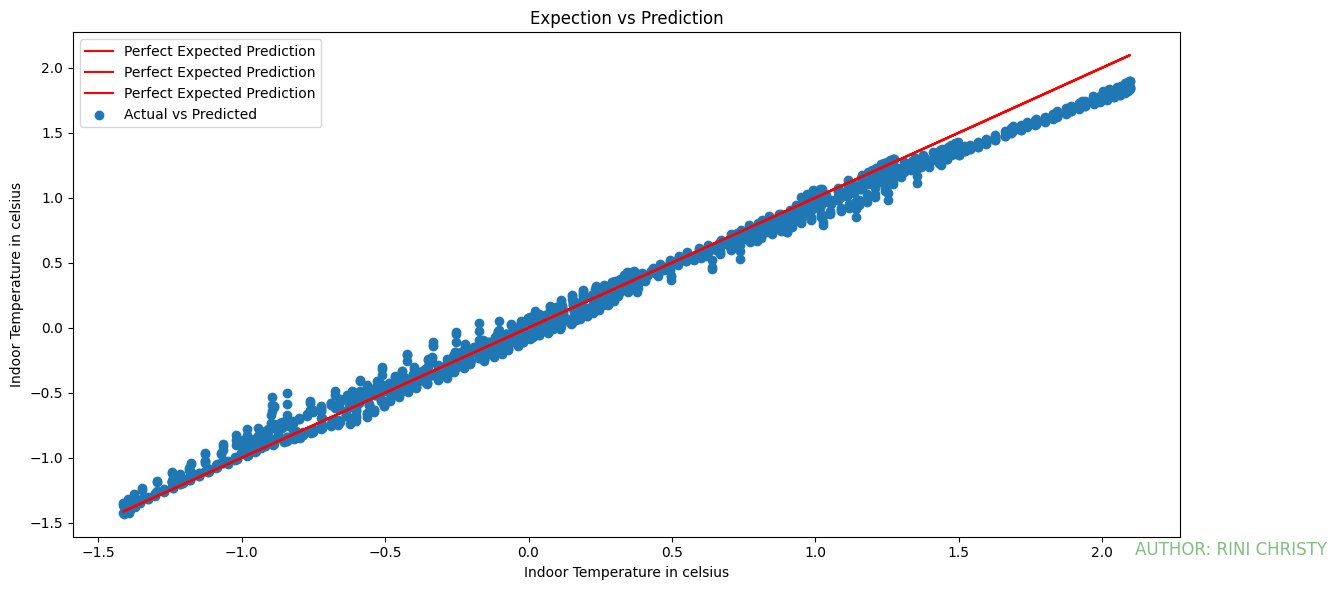

In [34]:
def model_train_evaluation(y, X, model, model_name):
    #Model run
    from tensorflow.keras.callbacks import EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    #history = model.fit(X_train,y_train, epochs=6,validation_data=(X_val, y_val),callbacks=early_stop)
    history = model.fit(X_train,y_train, epochs=6,validation_split=0.01, callbacks=early_stop)
    history_frame = pd.DataFrame(history.history)
    
    # model performance plot
    plt.figure(figsize=(20,5))
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='best')
    plt.title(model_name)
    plt.show()
    
    # Model Evaluation metrics
    from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score, r2_score, mean_absolute_percentage_error
    ypred =model.predict(X)
    print("\n \n Model Evaluation Report: ")
    print('Mean Absolute Error(MAE) of', model_name,':', mean_absolute_error(y, ypred))
    print('Mean Squared Error(MSE) of', model_name,':', mean_squared_error(y, ypred))
    print('Root Mean Squared Error (RMSE) of', model_name,':', mean_squared_error(y, ypred, squared = False))
    print('Mean absolute percentage error (MAPE) of', model_name,':', mean_absolute_percentage_error(y, ypred))
    print('Explained Variance Score (EVS) of', model_name,':', explained_variance_score(y, ypred))
    print('R2 of', model_name,':', (r2_score(y, ypred)).round(2))
    print('\n \n')
    
    # Actual vs Predicted Plot
    f, ax = plt.subplots(figsize=(12,6),dpi=100);
    plt.scatter(y, ypred, label="Actual vs Predicted")
    # Perfect predictions
    plt.xlabel('Indoor Temperature in celsius')
    plt.ylabel('Indoor Temperature in celsius')
    plt.title('Expection vs Prediction')
    plt.plot(y,y,'r', label="Perfect Expected Prediction")
    plt.legend()
    f.text(0.95, 0.06, 'AUTHOR: RINI CHRISTY',
         fontsize=12, color='green',
         ha='left', va='bottom', alpha=0.5);

model_train_evaluation(y_val, X_val,model_bi, 'Bidirectional LSTM model')

Epoch 1/6
69/69 [==============================] - 10s 49ms/step - loss: 0.2987 - val_loss: 0.0120
Epoch 2/6
69/69 [==============================] - 2s 25ms/step - loss: 0.0275 - val_loss: 0.0150
Epoch 3/6
69/69 [==============================] - 2s 26ms/step - loss: 0.0189 - val_loss: 0.0113
Epoch 4/6
69/69 [==============================] - 2s 26ms/step - loss: 0.0163 - val_loss: 0.0071
Epoch 5/6
69/69 [==============================] - 2s 26ms/step - loss: 0.0151 - val_loss: 0.0061
Epoch 6/6
69/69 [==============================] - 2s 25ms/step - loss: 0.0135 - val_loss: 0.0051


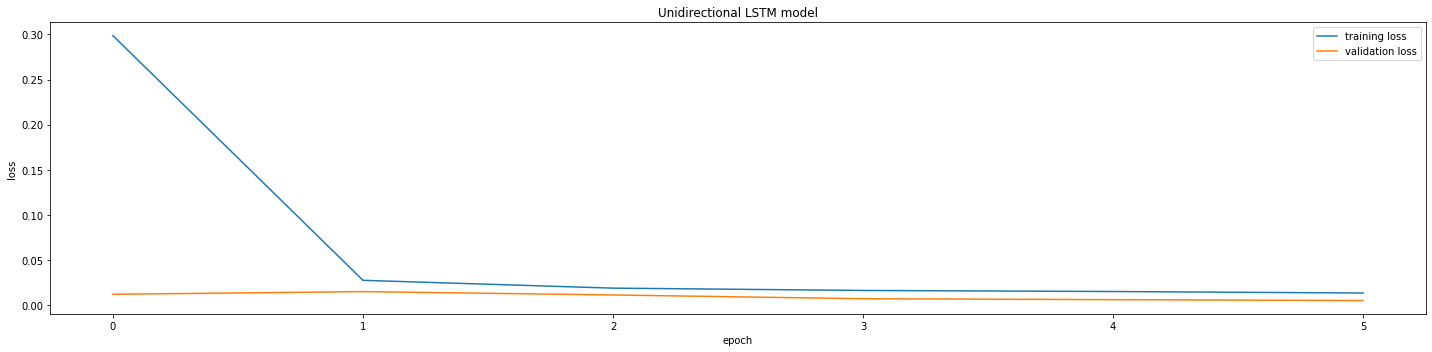


 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Unidirectional LSTM model : 0.06340048687611047
Mean Squared Error(MSE) of Unidirectional LSTM model : 0.006514554577172051
Root Mean Squared Error (RMSE) of Unidirectional LSTM model : 0.08049440072386216
Mean absolute percentage error (MAPE) of Unidirectional LSTM model : 0.9082240893574326
Explained Variance Score (EVS) of Unidirectional LSTM model : 0.9924980248138607
R2 of Unidirectional LSTM model : 0.99

 



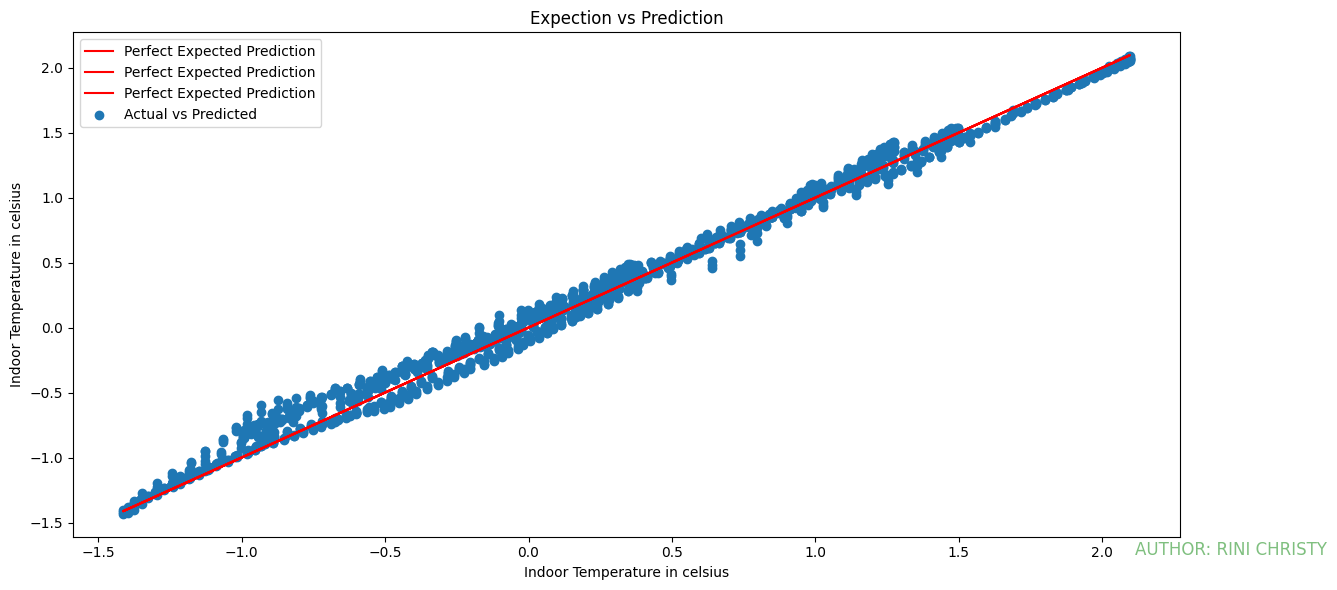

In [35]:
model_train_evaluation(y_val, X_val,model, 'Unidirectional LSTM model')

### **<span style = 'color:brown'>6.2 Model Forecast</span>**<a id = 'Forecast'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

In [36]:
df_test=pd.merge(df_test1['Id'],df_formatted_train_test,on='Id')
df_test=df_test[['Meteo_Sun_irradiance','hour','Outdoor_relative_humidity_Sensor']]
df_test

,Meteo_Sun_irradiance,hour,Outdoor_relative_humidity_Sensor
0,-3.12000,0,39.0800
1,-2.80800,0,38.9680
2,-2.96400,0,38.9467
3,-3.02933,0,39.0760
4,-2.88600,1,40.0413
...,...,...,...
1368,124.49600,6,58.9920
1369,256.59700,6,58.6213
1370,281.56800,7,57.6960
1371,354.64500,7,56.8613


In [37]:
train_test=df_train.append(df_test,ignore_index=True).fillna(0)
train_test

,Meteo_Sun_irradiance,hour,Outdoor_relative_humidity_Sensor,Indoor_temperature_room
0,758.880,11,48.3750,17.8275
1,762.069,12,47.8080,18.1207
2,766.251,12,47.4320,18.4367
3,766.037,12,47.0240,18.7513
4,762.743,12,45.4743,19.0414
...,...,...,...,...
4132,124.496,6,58.9920,0.0000
4133,256.597,6,58.6213,0.0000
4134,281.568,7,57.6960,0.0000
4135,354.645,7,56.8613,0.0000


**Inverse Scale Transform**

The standard score of a sample x is calculated as:

$ z = \frac{(x - u)} s $

So, x can be inverse scale transformed as, 

$x = (z * s)+u$

For that, first find the mean and standard deviation of dependent column. 


In [38]:
y_mean=df_train['Indoor_temperature_room'].mean()
y_std=scaler.scale_[df_train.shape[1]-1]
y_mean, y_std

(18.824852134587555, 2.8206675002719184)

Now, scale transform x to predict the unknown indoor temperature, which is then applied to the above formula to obtain the final forecasted result.

Start with bidirectional model. 

In [39]:
for i in range(len(df_train),len(train_test)):
    X_test=train_test[i-lags:i]
    X_test=scaler.transform(X_test)
    val=model_bi.predict(X_test.reshape(1,lags,X_test.shape[1]))
    val2=y_std*val[:,0]+y_mean
    train_test.loc[i,'Indoor_temperature_room']=val2
    
final_test = train_test[len(df_train):][['Indoor_temperature_room']]
final_test

,Indoor_temperature_room
2764,20.206810
2765,20.019564
2766,19.804260
2767,19.572138
2768,19.331560
...,...
4132,17.182802
4133,17.200636
4134,17.294888
4135,17.410963


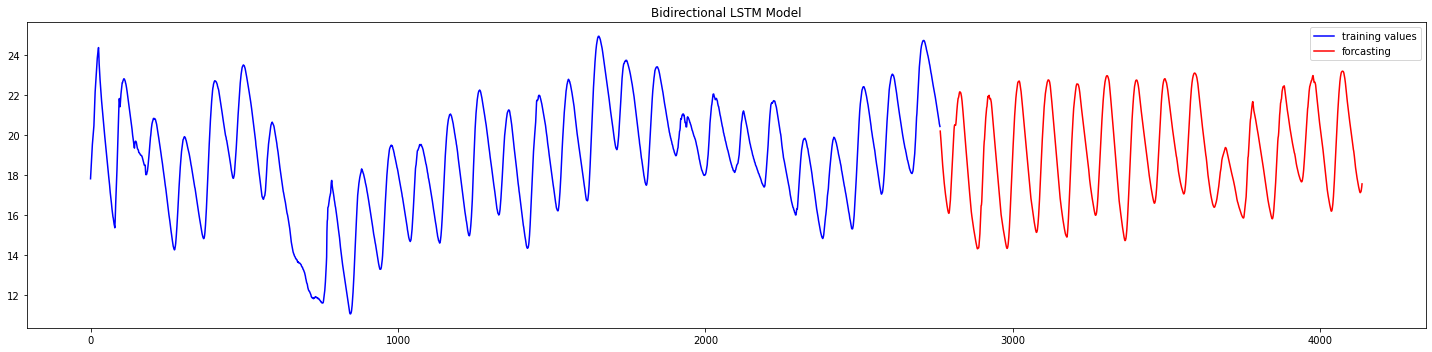

In [40]:
#Plot the Graph
plt.figure(figsize=(20,5))
plt.plot(df_train['Indoor_temperature_room'], label='training values', color = 'blue')
plt.plot(final_test['Indoor_temperature_room'], label='forcasting', color = 'red')
plt.legend(loc='best')
plt.title('Bidirectional LSTM Model')
plt.show()

Now, its the turn of Unidirectional model.

In [41]:
for i in range(len(df_train),len(train_test)):
    X_test=train_test[i-lags:i]
    X_test=scaler.transform(X_test)
    val=model.predict(X_test.reshape(1,lags,X_test.shape[1]))
    val2=y_std*val[:,0]+y_mean
    train_test.loc[i,'Indoor_temperature_room']=val2
    
final_test = train_test[len(df_train):][['Indoor_temperature_room']]
final_test

,Indoor_temperature_room
2764,20.523506
2765,20.470634
2766,20.425543
2767,20.371830
2768,20.294180
...,...
4132,19.408993
4133,19.442722
4134,19.505875
4135,19.600481


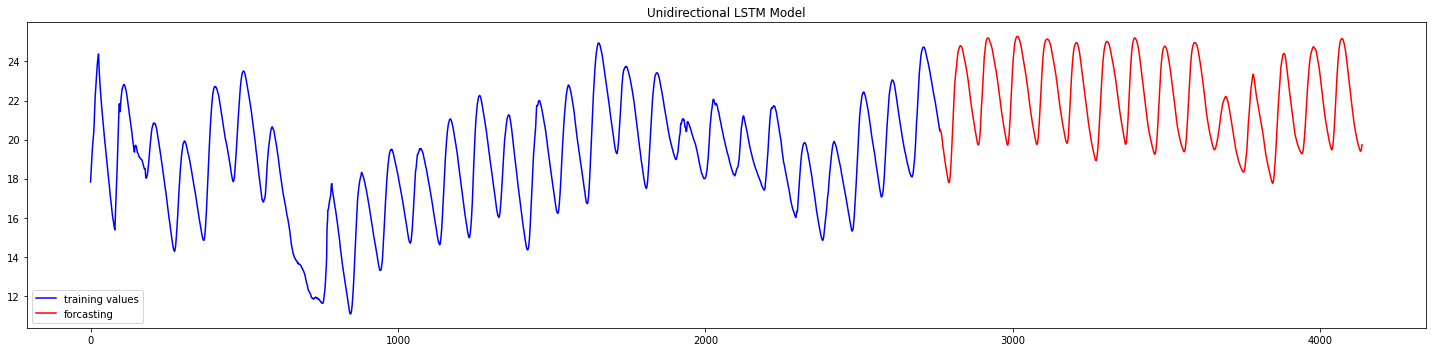

In [42]:
#Plot the Graph
plt.figure(figsize=(20,5))
plt.plot(df_train['Indoor_temperature_room'], label='training values', color = 'blue')
plt.plot(final_test['Indoor_temperature_room'], label='forcasting', color = 'red')
plt.title('Unidirectional LSTM Model')
plt.legend(loc='best')
plt.show()

### **<span style = 'color:brown'>6.3 Kaggle Submission</span>**<a id ="Submission"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)


In [43]:
final=pd.DataFrame({'Id':df_test1['Id'],'Indoor_temperature_room':np.array(train_test[len(df_train):]['Indoor_temperature_room'])})
final.to_csv('submission.csv',index=False)

### **Concluding remarks:**
It seems Univariate model has worked comparitively well with the chosen variables 'Meteo_Sun_irradiance','hour','Outdoor_relative_humidity_Sensor', 'Indoor_temperature_room', with a lag of 8. This is confirmed by the error metrics such as MAE, MSE, RMSE, MAPE etc. Bidirectional model eventhough it achieved pretty good accuracy, it seems overfitting the model, with a slightly higher error than unidirectional.  

### **References:**
1. [Hands-on Time Series Analysis with Python By   B V Vishwas,  Ashish Patel](https://link.springer.com/book/10.1007/978-1-4842-5992-4)


2. [Temperature Forecasting Analysis-part2 By PAVANKUMAR20](https://www.kaggle.com/code/pavankumar20/temperature-forecasting-analysis-part2)

Thanks for reading.

Obtained a score of 1.66 for this model.